In [ ]:
# Import the library to mount Google Drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow-probability pymc3 opencv-python pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 87.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pymc3 to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.9 MB/s eta 0:00:00
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529958 sha256=63d5cd9ba96b61b2353c3276cb67ffcf661b164467fe8015d156cc7f1bb95be3
  Stored in directory: /root/.cache/pip/wheels/fb/d3/25/6c443075ee21f3b6a59a6a180b55657b012722e1b89f8ccbe8
Successfully built theano-pymc


In [ ]:
pip install numpyro jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 29.0 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load and Parse Data

In [ ]:
def parse_filename(filename):
  # Extract the head pose and gaze angles from the file name
  parts = filename.split('_')
  head_pose = int(parts[2].replace('P',''))
  gaze_vertical = int(parts[3].replace('V',''))
  gaze_horizontal = int(parts[4].replace('H','').replace('.jpg',''))
  return head_pose,gaze_vertical, gaze_horizontal

def strip_extension(filename):
  return

def get_eye_corners(img_name, eye_corners_df):
  # Extract eye corners from the excel sheet
  # Check if img_name exists in the DataFrame before accessing it
  if img_name in eye_corners_df['IMAGE'].values:
    row = eye_corners_df[eye_corners_df['IMAGE'] == img_name].iloc[0]
    return {
          "right_eye": [(row["RIGHT_EYE_IN_X"], row["RIGHT_EYE_IN_Y"]),
                       (row["RIGHT_EYE_OUT_X"], row["RIGHT_EYE_OUT_Y"])],
          "left_eye": [(row["LEFT_EYE_IN_X"], row["LEFT_EYE_IN_Y"]),
                      (row["LEFT_EYE_OUT_X"], row["LEFT_EYE_OUT_Y"])]
      }
  else:
    # Handle cases where img_name is not found
    print(f"Warning: Image {img_name} not found in eye_corners_df")
    return {"right_eye": [], "left_eye": []}  # Or some default value

# Load data
data_dir = "/content/drive/MyDrive/CogRobs/Gaze_Dataset"
eye_corners_df = pd.read_csv("/content/drive/MyDrive/CogRobs/eye_corner_locations.csv")

images = []
head_poses = []
gaze_hs = []

for img_file in os.listdir(data_dir):
  if img_file.endswith(".jpg"):
    img_path = os.path.join(data_dir, img_file)
    head_pose, _, gaze_h = parse_filename(img_file)
    filename = os.path.splitext(img_file)[0]
    eye_corners = get_eye_corners(filename, eye_corners_df)
    # store data
    images.append(img_path)
    head_poses.append(head_pose)
    gaze_hs.append(gaze_h)



In [ ]:
print(eye_corners_df.columns)
print(eye_corners_df.head())


Index(['IMAGE', 'RIGHT_EYE_IN_X', 'RIGHT_EYE_IN_Y', 'RIGHT_EYE_OUT_X',
       'RIGHT_EYE_OUT_Y', 'LEFT_EYE_IN_X', 'LEFT_EYE_IN_Y', 'LEFT_EYE_OUT_X',
       'LEFT_EYE_OUT_Y'],
      dtype='object')
                    IMAGE  RIGHT_EYE_IN_X  RIGHT_EYE_IN_Y  RIGHT_EYE_OUT_X  \
0  0001_2m_-15P_-10V_-10H            2386            1627             2171   
1  0001_2m_-15P_-10V_-15H            2377            1620             2171   
2   0001_2m_-15P_-10V_-5H            2376            1614             2166   
3    0001_2m_-15P_-10V_0H            2387            1620             2184   
4   0001_2m_-15P_-10V_10H            2392            1613             2190   

   RIGHT_EYE_OUT_Y  LEFT_EYE_IN_X  LEFT_EYE_IN_Y  LEFT_EYE_OUT_X  \
0             1613           2754           1623            3009   
1             1606           2750           1611            3003   
2             1599           2752           1609            3012   
3             1601           2765           1616            30

In [ ]:
print(len(images))
print(len(head_poses))
print(len(gaze_hs))

5880
5880
5880


# Camera Configuration

In [ ]:
# Camera parameters
focal_length_mm = 85
sensor_width_mm = 22.3
original_width_px = 5184

# Focal length in pixels
focal_px = (focal_length_mm/sensor_width_mm)* original_width_px
camera_center_original = (original_width_px/2, original_width_px * (3456/5184)/2)

# Preprocess Images

In [ ]:
def preprocess_image(img_path, eye_corners, target_size=(224,224)):
  # Resize image and scale eye corners
  image = cv2.imread(img_path)
  original_h, original_w = image.shape[:2]
  image_resized = cv2.resize(image, target_size)

  # Scale eye corners to resized image
  scale_x = target_size[0]/original_w
  scale_y = target_size[1]/original_h
  eye_corners_scaled = {
       "right_eye": [(int(x * scale_x), int(y * scale_y)) for x, y in eye_corners["right_eye"]],
        "left_eye": [(int(x * scale_x), int(y * scale_y)) for x, y in eye_corners["left_eye"]]
  }

  # Scale camera parameters
  focal_px_scaled = focal_px * scale_x
  camera_center_scaled = (camera_center_original[0] * scale_x, camera_center_original[1] * scale_y)
  return image_resized, eye_corners_scaled, focal_px_scaled, camera_center_scaled

# Head Pose Estimation

In [ ]:
def estimate_head_pose(eye_corners, focal_px, camera_center):
  # Estimate haed yaw using solvePnP
  # 3d model
  model_3d = np.array([[-15.0,0,0],
                       [-5.0,0,0],
                       [5.0,0,0],
                       [15.0,0,0]],dtype=np.float32)

  # 2d points
  points_2d = np.array([
       eye_corners["left_eye"][1],  # Left outer
        eye_corners["left_eye"][0],  # Left inner
        eye_corners["right_eye"][0], # Right inner
        eye_corners["right_eye"][1]  # Right outer
  ], dtype=np.float32)

  # Camera matrix
  camera_matrix = np.array([
        [focal_px, 0, camera_center[0]],
        [0, focal_px, camera_center[1]],
        [0, 0, 1]
    ], dtype=np.float32)

  # Solve PnP
  _, rvec, _ = cv2.solvePnP(model_3d, points_2d, camera_matrix, None)
  rmat, _ = cv2.Rodrigues(rvec)
  yaw = np.degrees(np.arctan2(rmat[1,0], rmat[0,0]))
  return yaw

# Train Classifier

In [ ]:
def classify_head(yaw):
  return "left" if yaw < -15 else "right" if yaw > 15 else "center"

def classify_gaze(gaze_h):
  return "left" if gaze_h < -5 else "right" if gaze_h > 5 else "center"

# Preprocess all images
X = []
y_head = []
y_gaze = []

for img_path, head_pose, gaze_h, eye_corners in zip(images, head_poses, gaze_hs, [get_eye_corners(os.path.splitext(f)[0], eye_corners_df) for f in os.listdir(data_dir) if f.endswith(".jpg")]):
  img_resized, _, _, _ = preprocess_image(img_path, eye_corners)
  X.append(img_resized)
  y_head.append(classify_head(head_pose))  # Use ground truth from filename
  y_gaze.append(classify_gaze(gaze_h))

# Convert labels to indices
label_map = {"left": 0, "center": 1, "right":2}
y_head_idx = np.array([label_map[h] for h in y_head])
y_gaze_idx = np.array([label_map[g] for g in y_gaze])

X_train, X_test, y_head_train, y_head_test, y_gaze_train, y_gaze_test = train_test_split(np.array(X), y_head_idx, y_gaze_idx, test_size=0.2)


# CNN Model
def CNN_model(input_shape, num_classes):
  base_model = tf.keras.applications.MobileNetV2(
      input_shape=input_shape,
      include_top=False,
      weights="imagenet"
  )

  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(num_classes, activation="softmax")
  ])

  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

  # Train head direction classifier
head_model = CNN_model(input_shape=(224,224,3), num_classes=3)
head_model.fit(X_train, y_head_train, epochs=10, validation_data=(X_test, y_head_test))

  # Train gaze direction classifier
gaze_model = CNN_model(input_shape=(224,224,3), num_classes=3)
gaze_model.fit(X_train, y_gaze_train, epochs=10, validation_data=(X_test, y_gaze_test))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 70s 105ms/step - accuracy: 0.9328 - loss: 0.1863 - val_accuracy: 0.6650 - val_loss: 9.9682
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 1.0000 - loss: 5.9648e-04 - val_accuracy: 0.7764 - val_loss: 5.5702
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 1.0000 - loss: 4.8848e-05 - val_accuracy: 0.8435 - val_loss: 2.1255
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 1.0000 - loss: 4.5848e-05 - val_accuracy: 0.9303 - val_loss: 0.4597
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 1.0000 - loss: 5.3290e-05 - val_accuracy: 0.9796 - val_loss: 0.0604
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 1.0000 - loss: 8.4388e-06 - val_accuracy: 0.9983 - val_loss: 0.0064
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 1.0000 - loss: 7.5729e-06 - val_accuracy: 1.0000 - val_loss: 5.5368e-04
Epoch 8/10
147/147

# Visualisation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

head_eval = head_model.evaluate(X_test, y_head_test, verbose=0)
print(f"Head Model - Test Loss: {head_eval[0]:.4f}, Test Accuracy: {head_eval[1]:.4f}")

head_preds = np.argmax(head_model.predict(X_test), axis=1)
print("\nHead Model CLassification Report:")
print(classification_report(y_head_test, head_preds, target_names=["left", "center","right"]))

# display confusion matrix for head model
print("\nHead Model Confusion Matrix:")
print(confusion_matrix(y_head_test, head_preds))

# display gaze model
gaze_eval = gaze_model.evaluate(X_test, y_gaze_test, verbose=0)
print(f"Gaze Model - Test Loss: {gaze_eval[0]:.4f}, Test Accuracy: {gaze_eval[1]:.4f}")

gaze_preds = np.argmax(gaze_model.predict(X_test), axis=1)
print("\nGaze Model CLassification Report:")
print(classification_report(y_gaze_test, gaze_preds, target_names=["left", "center","right"]))

print("\nGaze Model Confusion Matrix:")
print(confusion_matrix(y_gaze_test, gaze_preds))

Head Model - Test Loss: 0.0000, Test Accuracy: 1.0000
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Head Model CLassification Report:
              precision    recall  f1-score   support

        left       1.00      1.00      1.00       225
      center       1.00      1.00      1.00       693
       right       1.00      1.00      1.00       258

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176


Head Model Confusion Matrix:
[[225   0   0]
 [  0 693   0]
 [  0   0 258]]
Gaze Model - Test Loss: 1.1803, Test Accuracy: 0.2917
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step

Gaze Model CLassification Report:
              precision    recall  f1-score   support

        left       0.29      1.00      0.45       342
      center       0.50      0.00      0.01       486
       right       0.00      0.00      0.00       348

    accuracy                           0.29      1176
   macro avg  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Plots

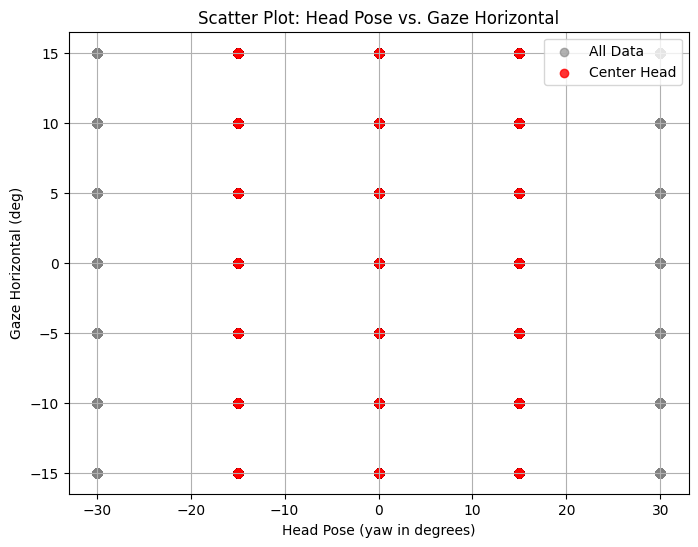

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to NumPy arrays for easier indexing
head_poses_arr = np.array(head_poses)
gaze_hs_arr = np.array(gaze_hs)
y_head_arr = np.array(y_head)

# Create scatter plot for all data points
plt.figure(figsize=(8, 6))
plt.scatter(head_poses_arr, gaze_hs_arr, alpha=0.6, label='All Data', color='gray')

# Filter indices where head is classified as "center"
center_indices = np.where(y_head_arr == "center")[0]

# Highlight data points with center head position in red
plt.scatter(head_poses_arr[center_indices], gaze_hs_arr[center_indices],
            alpha=0.8, label='Center Head', color='red')

plt.xlabel("Head Pose (yaw in degrees)")
plt.ylabel("Gaze Horizontal (deg)")
plt.title("Scatter Plot: Head Pose vs. Gaze Horizontal")
plt.legend()
plt.grid(True)
plt.show()


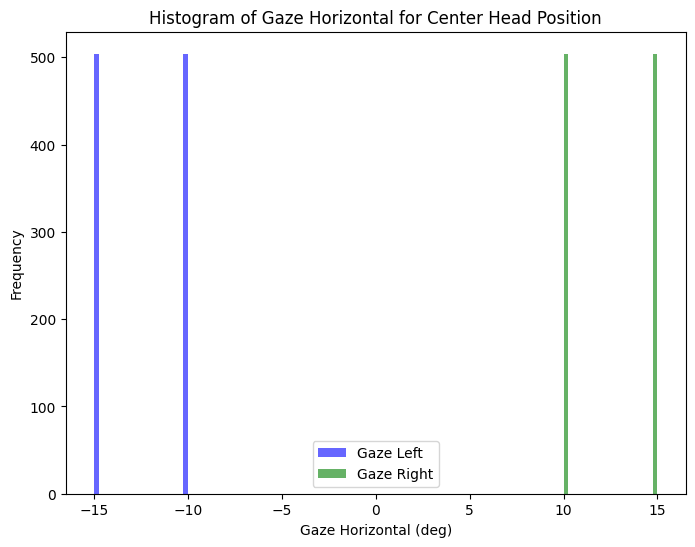

In [ ]:
# Assuming y_gaze is a list of categorical gaze labels ("left", "center", "right")
y_gaze_arr = np.array(y_gaze)

# Filter gaze horizontal values for center head position
gaze_center = gaze_hs_arr[center_indices]
gaze_labels_center = y_gaze_arr[center_indices]

# Further separate into "left" and "right" gaze responses (ignoring those labeled "center")
gaze_left = gaze_center[gaze_labels_center == "left"]
gaze_right = gaze_center[gaze_labels_center == "right"]

plt.figure(figsize=(8, 6))
plt.hist(gaze_left, bins=20, alpha=0.6, label="Gaze Left", color='blue')
plt.hist(gaze_right, bins=20, alpha=0.6, label="Gaze Right", color='green')

plt.xlabel("Gaze Horizontal (deg)")
plt.ylabel("Frequency")
plt.title("Histogram of Gaze Horizontal for Center Head Position")
plt.legend()
plt.show()


# Bayesian Analysis

In [ ]:
import numpyro
import jax
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Convert data to JAX arrays
head_poses_jax = jnp.array(head_poses)
gaze_hs_jax = jnp.array(gaze_hs)

def gaze_model(head_poses, gaze_hs=None):
    # Priors
    alpha = numpyro.sample("alpha", dist.Normal(0, 10))
    beta = numpyro.sample("beta", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.HalfNormal(10))

    # Likelihood
    mu = alpha + beta * head_poses
    numpyro.sample("gaze", dist.Normal(mu, sigma), obs=gaze_hs)

# Run MCMC
nuts_kernel = NUTS(gaze_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000)
mcmc.run(jax.random.PRNGKey(0), head_poses_jax, gaze_hs_jax)

# Get samples and plot
samples = mcmc.get_samples()
plt.figure(figsize=(8, 4))
plt.hist(samples["beta"], bins=30, density=True, alpha=0.7)
plt.title("Posterior Distribution of Beta (Head Pose Effect)")
plt.xlabel("Beta Value")
plt.ylabel("Density")
plt.show()

# Print summary
print("\nBayesian Inference Results:")
print(f"Alpha mean: {jnp.mean(samples['alpha']):.2f} ± {jnp.std(samples['alpha']):.2f}")
print(f"Beta mean: {jnp.mean(samples['beta']):.2f} ± {jnp.std(samples['beta']):.2f}")
print(f"Sigma mean: {jnp.mean(samples['sigma']):.2f} ± {jnp.std(samples['sigma']):.2f}")